In [185]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset


import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [186]:
print(os.getcwd())

C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums


In [187]:
# Declare important variables
train_path = 'train.csv'
test_path = 'test.csv'
target_variable = 'Premium Amount'
rng = 69

In [188]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    if socket.gethostname() == 'zchodani-p-l01':
        file_directory = r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    elif socket.gethostname() == 'FTILC3VBil7BwCe':
        file_directory = r"C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    else:
        file_directory = r"C:\Users\zanec\OneDrive\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
         
    os.chdir(file_directory)

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    return df1, df2

In [189]:
df_train, df_test = load_dataframes(train_path,test_path)

In [190]:
df_train = df_train.drop('id',axis=1)
df_test = df_test.drop('id',axis=1)

In [191]:
from typing import Tuple

def plot_kde_grid(df: pd.DataFrame, n_cols: int = 4, figsize: Tuple[int, int] = (12,8)) -> None:
    """
    Plots KDE for all numeric columns in the dataframe in a grid layout.
    
    Parameters:
        df (pd.DataFrame): DataFrame with numeric columns to plot.
        n_cols (int): Number of columns in the grid (default is 3).
        figsize (tuple): Size of the entire figure (default is (12, 8)).
    
    Returns:
        None
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    
    # Set up grid size
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))  # Number of rows based on the number of features
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize))  # Adjust figure size
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    # Hide any unused subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

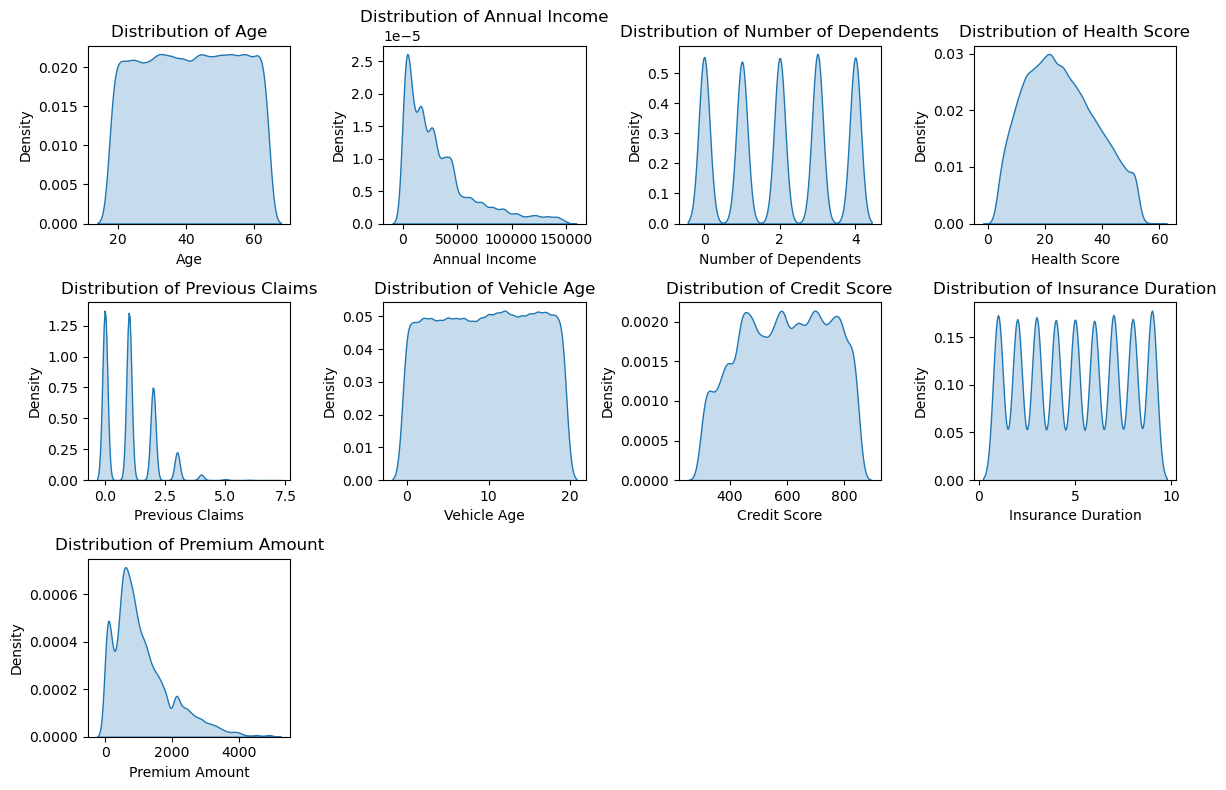

In [192]:
plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

In [193]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
    # Plot unique values
    fig, ax = plt.subplots(1, 1, figsize=(24, 5))
    sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
    ax.set_title(f'{name} Unique Values')
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.show()

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,1540,1.540000,47,0,18.000000,64.000000,41.176000,13.549630,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,3792,3.792000,33760,0,2.000000,149996.000000,32761.461750,32179.156965,nan,nan
3,Marital Status,object,1553,1.553000,3,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,9105,9.105000,5,0,0.000000,4.000000,2.007976,1.415089,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,object,29818,29.818000,3,0,nan,nan,nan,nan,Employed,23568
7,Health Score,float64,5968,5.968000,76632,0,2.053458,58.886035,25.609103,12.195576,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


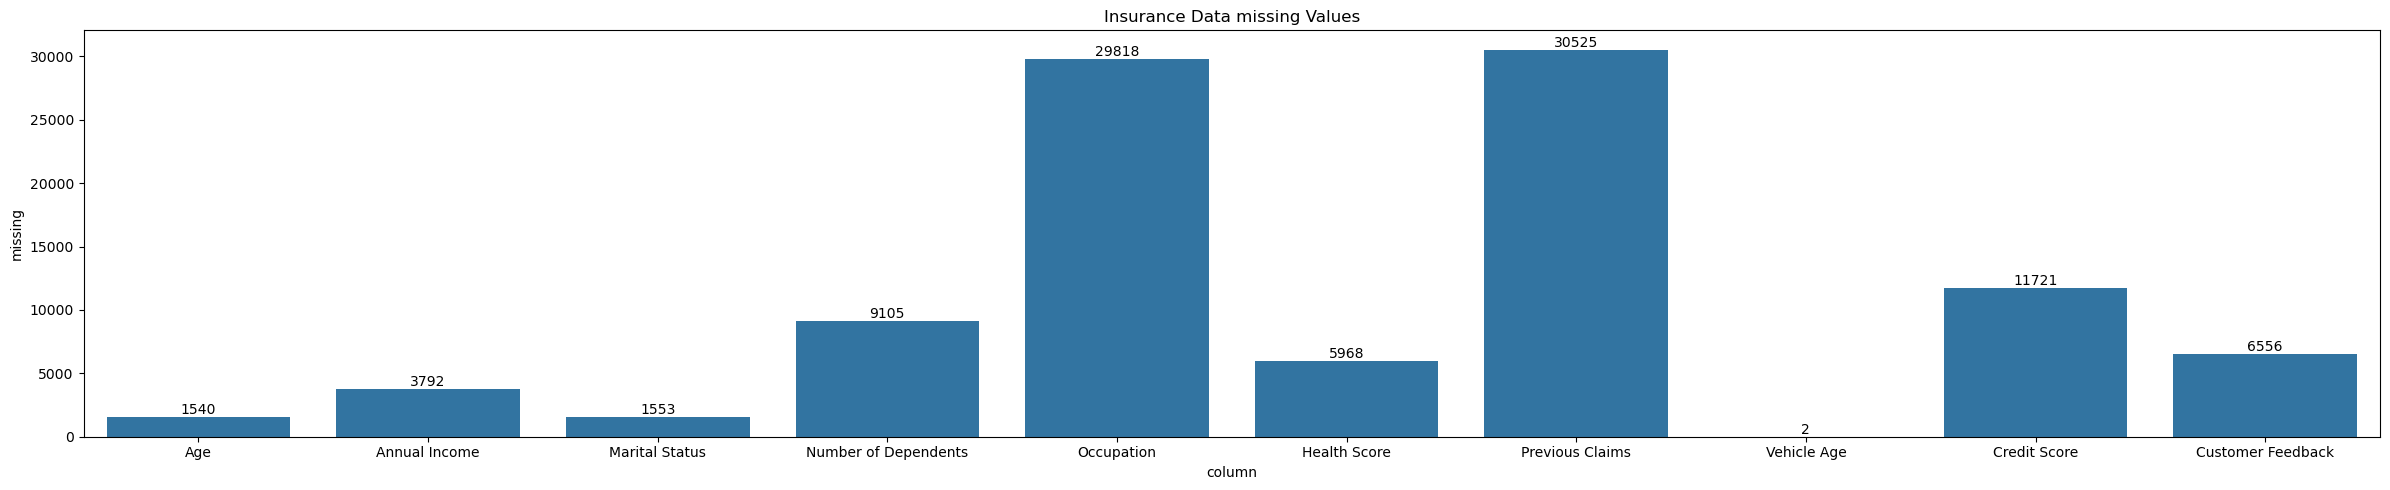

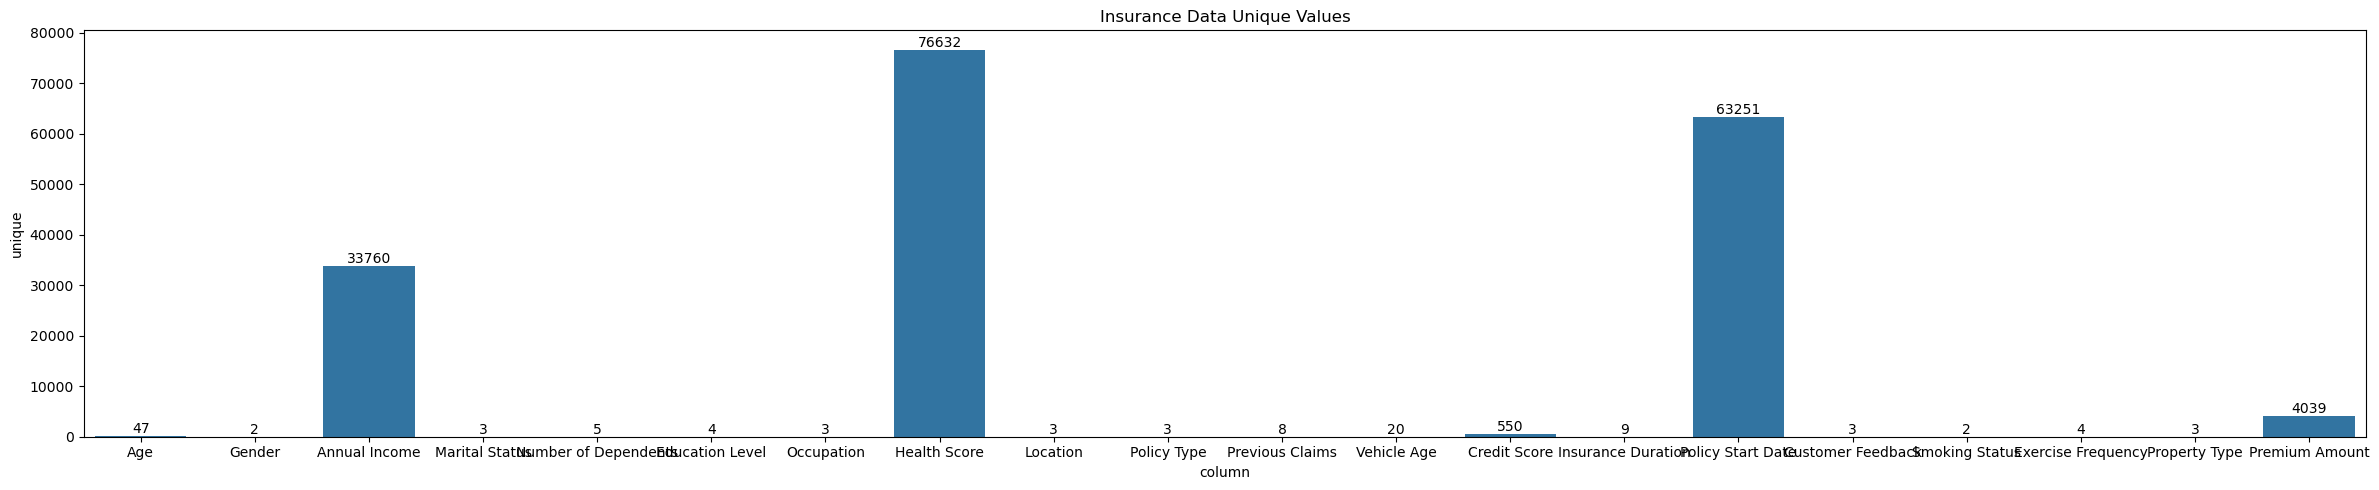

In [194]:
describe_dataframe(df_train, name='Insurance Data', nrows=0, plots=True, info=True)

In [195]:
def clean_dataframe(df_to_use: pd.DataFrame) -> None:
    df = df_to_use.copy()
    
    # inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    # df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})  
    # # Merge the two DataFrames on 'column'
    # inf['missing'] = df_missing['missing'] 
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=[np.float64, np.int64]).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

     # Fill nulls in numeric columns with the median
    for column in missing_numeric_columns:
        mdn = df[column].median()
        df[column] = df[column].fillna(mdn)

    
    # Get object columns
    object_columns = df.select_dtypes(include=['object', 'string']).columns.tolist()  
    # Fill missing values in object columns
    for column in object_columns:
        df[column] = df[column].fillna('Unknown')
    # Convert object columns to string
    for column in object_columns:
        df[column] = df[column].astype('string')
    
    return df

In [196]:
df_train_cleaned = clean_dataframe(df_train)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.173290,13.444909,nan,nan
1,Gender,string,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,0,0.000000,33760,0,2.000000,149996.000000,32424.942160,31608.620253,nan,nan
3,Marital Status,string,0,0.000000,4,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.007250,1.349131,nan,nan
5,Education Level,string,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,string,0,0.000000,4,0,nan,nan,nan,nan,Unknown,29818
7,Health Score,float64,0,0.000000,76633,0,2.053458,58.886035,25.548309,11.828520,nan,nan
8,Location,string,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,string,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


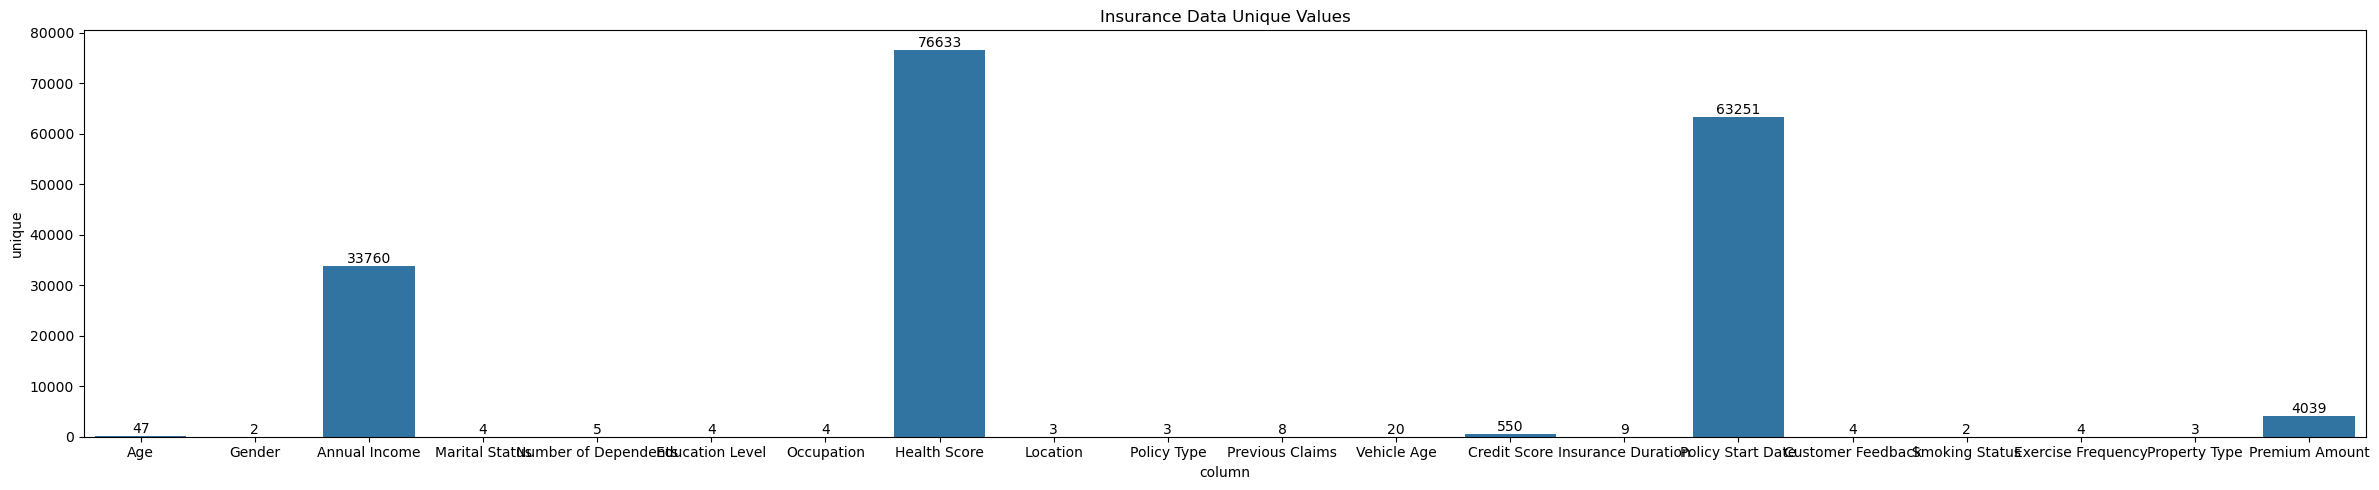

In [197]:
describe_dataframe(df_train_cleaned, name='Insurance Data', nrows=0, plots=True, info=True)

In [198]:
def transform_dataframe(df_to_use: pd.DataFrame) -> None:
    
    df = df_to_use.copy()
    
    # Transform Date Fields
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month Name'] = df['Policy Start Date'].dt.month_name()
    df['Day of Week'] = df['Policy Start Date'].dt.day_name()
    #df['Week'] = df['Policy Start Date'].dt.isocalendar().week.astype('int32')
    df['Year Sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year Cos'] = np.cos(2 * np.pi * df['Year'])
    df['Month Sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day Sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day Cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    #df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df = df.drop('Policy Start Date', axis=1)


    # List of columns to encode
    columns_to_encode = [
        'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
        'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
        'Property Type','Month Name','Day of Week'
    ]
    
    # Apply frequency encoding to Categories
    for col in columns_to_encode:
        # Get the column names before encoding
        existing_columns = set(df.columns)
        
        freq_encoding = df[col].value_counts()  # Count occurrences
        df[f'{col}_Freq'] = df[col].map(freq_encoding).astype('int32')  # Map frequencies to the original data
        
        
    df = df.drop(columns=columns_to_encode, axis=1)

    return df

In [199]:
df_train_prepared = transform_dataframe(df_train_cleaned)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.173290,13.444909
1,Annual Income,float64,0,0.000000,33760,0,2.000000,149996.000000,32424.942160,31608.620253
2,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.007250,1.349131
3,Health Score,float64,0,0.000000,76633,0,2.053458,58.886035,25.548309,11.828520
4,Previous Claims,float64,0,0.000000,8,0,0.000000,7.000000,1.002630,0.817771
5,Vehicle Age,float64,0,0.000000,20,0,0.000000,19.000000,9.579530,5.769072
6,Credit Score,float64,0,0.000000,550,0,300.000000,849.000000,592.248550,140.797800
7,Insurance Duration,float64,0,0.000000,9,0,1.000000,9.000000,5.015680,2.597168
8,Premium Amount,float64,0,0.000000,4039,0,20.000000,4994.000000,1103.679570,867.418049
9,Year,int32,0,0.000000,6,0,2019.000000,2024.000000,2021.618300,1.478948


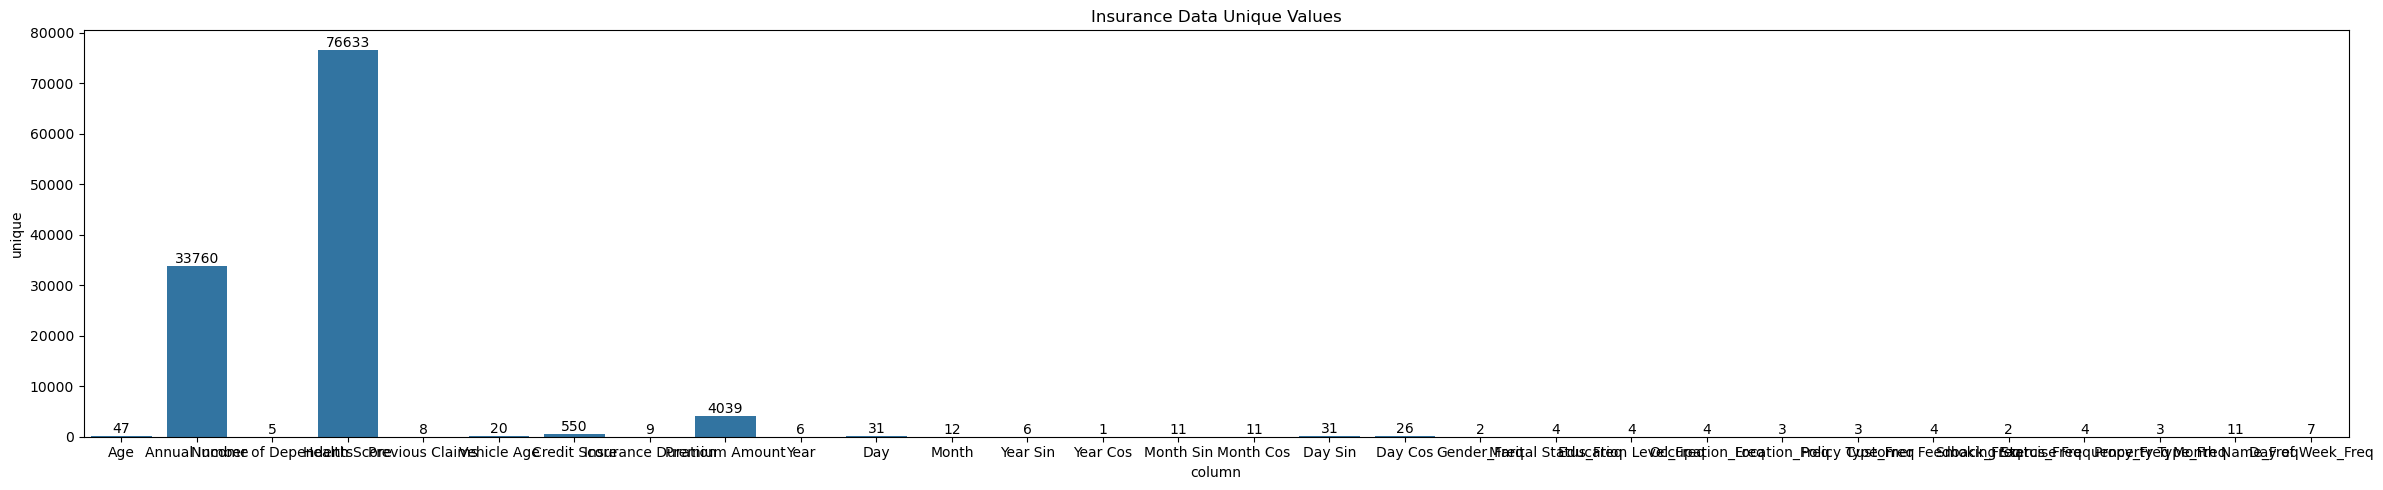

In [200]:
describe_dataframe(df_train_prepared, name='Insurance Data', nrows=0, plots=True, info=True)

'\nPositive Corr: \n    Credit Score / Annual Income\n    Premium Amount / Previous Claims\n    Year / Group (too high, should remove)\n    Week / Month (too high, should remove)\n'

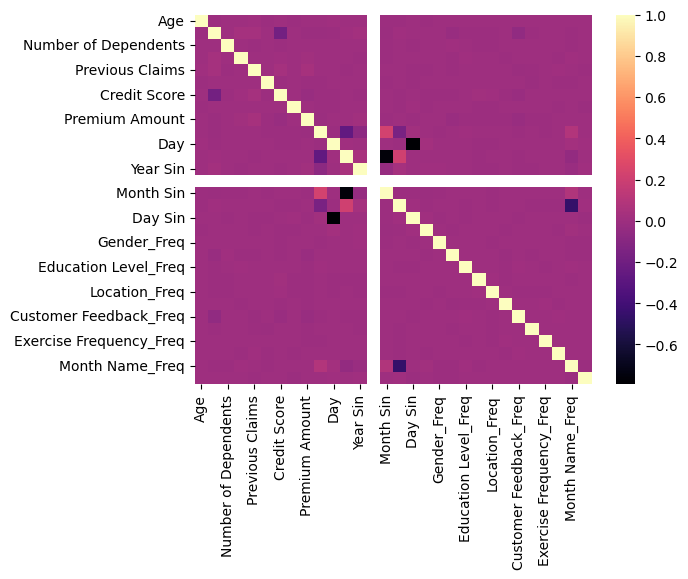

In [202]:
sns.heatmap(df_train_prepared.corr(), annot=False, cmap='magma')
"""
Positive Corr: 
    Credit Score / Annual Income
    Premium Amount / Previous Claims
    Year / Group (too high, should remove)
    Week / Month (too high, should remove)
"""

In [206]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data

X = df_train_prepared.drop('Premium Amount', axis=1)
y = df_train_prepared['Premium Amount'].copy()

X_train_initial, X_test, y_train_initial, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

# Now split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_initial, y_train_initial, test_size=0.25, random_state=rng)


y_log_train = np.log1p(y_train)
y_log_val = np.log1p(y_val)
y_log_test = np.log1p(y_test)

In [208]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

X_train_prepared= num_pipeline.fit_transform(X_train)
X_val_prepared= num_pipeline.fit_transform(X_val)
X_test_prepared= num_pipeline.fit_transform(X_test)


In [210]:
from keras import backend as K
from sklearn.metrics import mean_squared_log_error

#Define a custom RMSLE metric
def rmsle(y_true, y_pred):  
    # To avoid log(0), clip values to a small positive constant (epsilon)
    epsilon = tf.keras.backend.epsilon()

    # Apply log transformation
    #y_true_log = tf.math.log1p(y_true)  # Log-transform the true values
    #y_pred_log = tf.math.log1p(y_pred)  # Log-transform the clipped predicted values
    
    # RMSLE formula
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [212]:
from tensorflow import keras
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [253]:
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    'num_leaves': [15, 31, 70],
    #'max_depth': [-1, 5, 10],
    'learning_rate': [0.01,.001,.0001],
    'n_estimators': [200, 500, 1000],
    #'subsample': [0.8, 1.0],
    #'colsample_bytree': [0.8, 1.0]
}

lgbm = lgb.LGBMRegressor(random_state=rng)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Use RMSE as the evaluation metric
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Output progress messages
    n_jobs=-1  # Use all available cores
)

grid.fit(X_train_prepared, y_log_train,feature_name=X.columns.tolist())

print("Best parameters:", grid.best_params_)
print("Best RMSE:", (-grid.best_score_)**0.5)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 28
[LightGBM] [Info] Start training from score 6.592863
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 28
[LightGBM] [Info] Start training from score 6.598396
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [

In [247]:
print("Best parameters:", grid.best_params_)
print("Best RMSE:", (-grid.best_score_)**0.5)

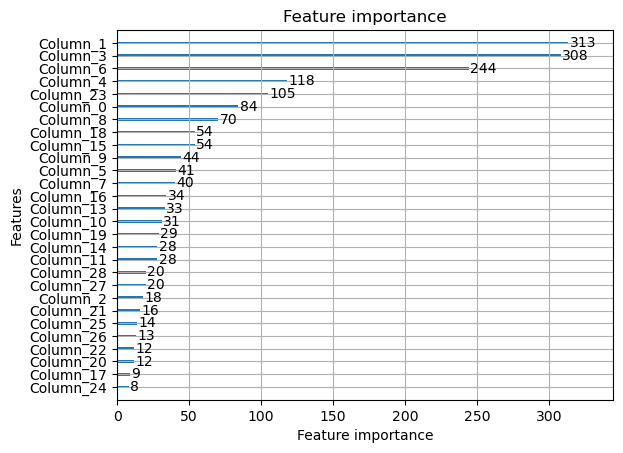

In [262]:
import matplotlib.pyplot as plt
# Plot feature importance
lgb.plot_importance(model, max_num_features=X_train_prepared.shape[1], importance_type='split')
plt.show()

In [214]:
import lightgbm as lgb


# Initialize the LGBMRegressor
model = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient Boosted Decision Trees
    n_estimators=1000,     # Number of boosting rounds
    learning_rate=0.05,    # Step size for updates
    max_depth=-1,          # No limit on depth
    num_leaves=31,         # Number of leaves in a tree
    random_state=rng        # Ensure reproducibility
)

# Train the model
model.fit(
    X_train_prepared, 
    y_log_train, 
    eval_set=[(X_val_prepared, y_log_val)], 
    eval_metric='rmse',        # Evaluation metric (root mean squared error)
    callbacks=[lgb.early_stopping(50)]  # Stop early if no improvement
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1051
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 28
[LightGBM] [Info] Start training from score 6.595326
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 1.04906	valid_0's l2: 1.10053


LGBMRegressor(learning_rate=0.05, n_estimators=1000, random_state=69)

In [216]:
# Predict on test set
y_pred = model.predict(X_test_prepared)

In [218]:
from sklearn.metrics import root_mean_squared_error

# Calculate RMSE
rmse = root_mean_squared_error(y_log_test, y_pred)
print(f"RMSE: {rmse:.2f}")

RMSE: 1.07


C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
